In [205]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import sys
sys.path.append('../')

In [19]:
import os
import json
import matplotlib.pyplot as plt
import matplotlib.cm
from collections import defaultdict
from dotenv import load_dotenv
from control.manager import Manager
from objects.resource import Resources
from objects.goal import Goal
from objects.trade import Trade

from agents.chatgpt import ChatGPTAgent

In [29]:
def load_states(paths):
    states = {}
    for exp_path in paths:
        try:
            with open(os.path.join(exp_path,"state.json")) as f:
                states[exp_path] = json.load(f)
        except:
            print(exp_path, "bad")
    return states

In [6]:
def compute_metric_from_state(exp_state, metric_fn, metric_store: defaultdict):
    for agent_id, agent_state in enumerate(exp_state):
         metric_fn(agent_id, agent_state, metric_store)
    return metric_store

def agent_proposal_utility_fn(agent_id, agent_state, metric_store):
    for state in agent_state[1:]:
        if state['proposed_trade'] != "None":
            # convert string into objects
            resources = Resources.from_string(state['resources'])
            goals = Goal.from_string(state['goals'])
            proposed_trade = Trade.from_string(state['proposed_trade'])
            # mini hack to get the right sign
            marginal_utility = goals-resources if agent_id == 0 else resources-goals
            marginal_utility.resource_dict = { k : max(v,0) for k,v in  marginal_utility.resource_dict.items()}
            metric_store[agent_id].append(proposed_trade.minimal_utility(resources, goals, dir=agent_id ))

def agent_success_fn(agent_id, agent_state, metric_store):
    state = agent_state[-1]
    goals = Goal.from_string(state['goals'])
    resources = Resources.from_string(state['resources'])
    goal_reached = goals.goal_reached(resources)
    metric_store[agent_id] = goal_reached



In [7]:
def agent_proposal_utility(states):
    return [compute_metric_from_state(_, agent_proposal_utility_fn, defaultdict(list)) for _ in states.values()]

def agent_success(states):
    return [compute_metric_from_state(_, agent_success_fn, defaultdict(bool)) for _ in states.values()]

def agent_average_success(states):
    success = agent_success(states)
    return { k: sum([trial[k] for trial in success])/len(success)  for k in success[0].keys() }
                          

In [13]:
s = """1698815132145
1698815186523
1698815270763
1698815303029
1698815386619
1698815423154
1698815528219
1698815557131
1698815721505
1698815783022
1698815890071
1698815957749
1698815998372
1698816044912
1698816066230
1698816203031
1698816389689
1698816438364
1698816591865
1698816804982"""

In [14]:
s = [int(k) for k in s.split("\n")]

In [16]:
fair = s[0:5]
unfair = s[5:10]
fair_beg = s[10:15]
unfair_beg = s[15:20]

In [39]:
paths = [
    f"../.logs/{f}" for f in fair_beg
]
states = load_states(paths)

../.logs/1698816044912 bad


In [40]:
proposal_utilities = agent_proposal_utility(states)
success = agent_success(states)
avg_success = agent_average_success(states)

In [59]:
states[list(states.keys()[0])][-1][-2]

SyntaxError: incomplete input (2426926153.py, line 1)

Text(0.5, 1.0, 'Trade Success Rate')

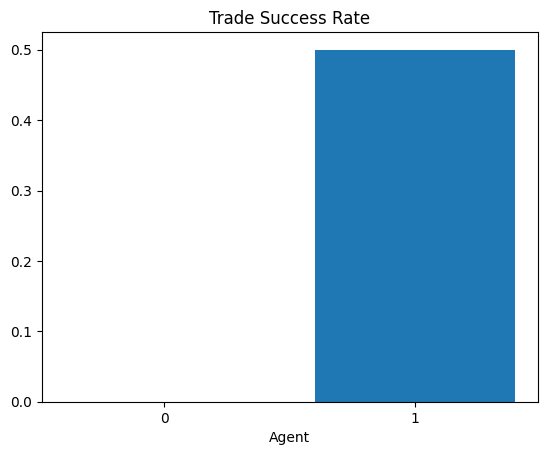

In [41]:
plt.bar(avg_success.keys(), avg_success.values(), tick_label=list(avg_success.keys()))
plt.xlabel('Agent')
plt.title('Trade Success Rate')

In [22]:
proposal_utilities

[defaultdict(list, {0: [0], 1: [-5.0]}),
 defaultdict(list, {0: [-5.0, -7.0, -8.0], 1: [-8.0, -7.0]}),
 defaultdict(list, {0: [0]}),
 defaultdict(list, {0: [-5.0, -3.0, -2.0], 1: [0, -2.0]}),
 defaultdict(list, {0: [0]})]

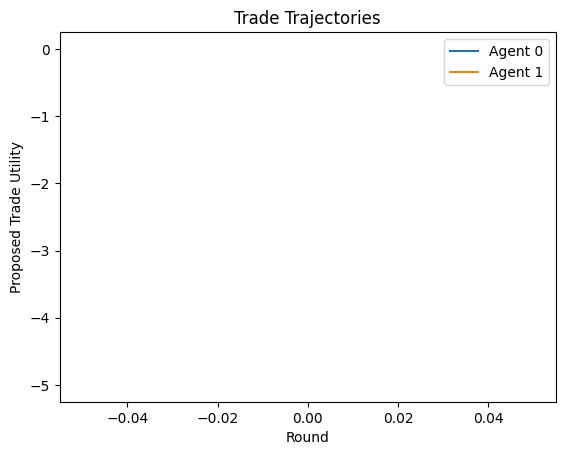

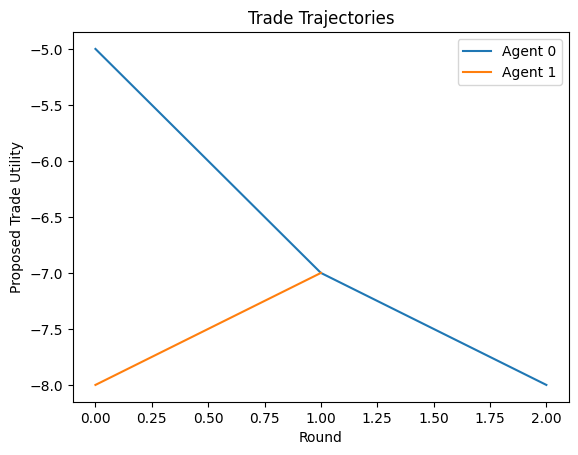

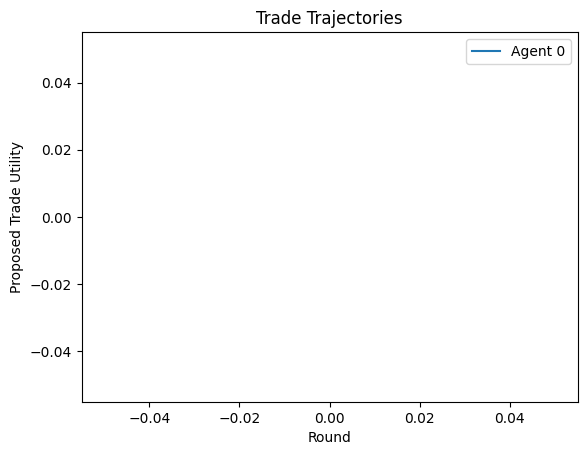

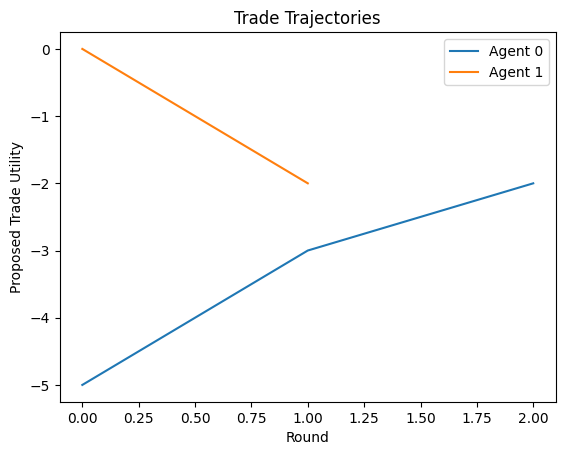

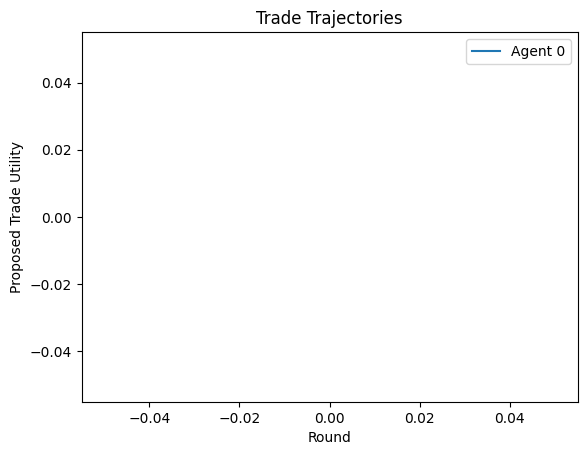

In [23]:
color = matplotlib.cm.datad['tab10']['listed']
for util in proposal_utilities:
    for idx, _ in enumerate(util.values()):
        plt.plot(_, color=color[idx], alpha=1, linewidth=1.5)

    plt.legend(['Agent 0', 'Agent 1'])
    plt.xlabel('Round')
    plt.ylabel('Proposed Trade Utility')
    # plt.yscale('log')
    plt.title("Trade Trajectories")
    plt.show()

In [72]:
proposal_utilities

[defaultdict(list, {0: [5.0, 3.0, 0.0], 1: [0.0, 0.0]}),
 defaultdict(list, {0: [5.0, 0.0, -1.0], 1: [5.0, 5.0]}),
 defaultdict(list, {0: [5.0, 0.0], 1: [0.0]}),
 defaultdict(list, {0: [5.0, -3.0], 1: [5.0]}),
 defaultdict(list, {0: [5.0, 0.0, -1.0], 1: [5.0, 3.0]}),
 defaultdict(list, {0: [8.0, 0.0], 1: [0.0]}),
 defaultdict(list, {0: [0.0], 1: [2.0]}),
 defaultdict(list, {0: [5.0, -3.0], 1: [5.0]})]

In [ ]:
minimal_utility
overall_utility

In [88]:
G ( x = 15, y = 15),

25, 5, minimal => -10, overall 0

(x = 20, y = 10) => minimal -5, overall 0
(x = 20, y = 13) => minimal -2, overall 3
(x = 40, y = 10) => minimal -5, overall 10
(x = 25, y = 0) => minimal -15, overall -5


SyntaxError: invalid syntax. Maybe you meant '==' or ':=' instead of '='? (786211949.py, line 3)